# OST - DATA PREPROCESSING EXTENSION

We will be using Jupyter notebook to preprocess captured data by OST main application for final analysis

### Import and Install Dependacies

We will be using following dependencies to achieve clean dataset

-**Pandas** - For dataset manipulation

In [1]:
# Install necessary libraries
!pip install pandas numpy scipy

In [10]:
# For smoothing
from scipy.signal import savgol_filter

# For array manipulation
import numpy as np

# Pandas for data manipulation
import pandas as pd

# For visualization
import matplotlib.pyplot as plt

### Delete unnessary joints 

We dont need all the joints that mediapipe captures. Before doing any operations on the data these extra joints should be removed   
**Joint ID are mapped as below picture**

<img src="assets/pose_landmarks_index.png" alt="drawing" width="400"/>

Data shape: (25410, 52)
Columns: Index(['timestamp', 'joint_0_x', 'joint_0_y', 'joint_0_z', 'joint_11_x',
       'joint_11_y', 'joint_11_z', 'joint_12_x', 'joint_12_y', 'joint_12_z'],
      dtype='object')...

=== DATA STRUCTURE DEBUG ===
Total rows: 25410
Columns: 52

Joint columns found: 51
  joint_0_x
  joint_0_y
  joint_0_z
  joint_11_x
  joint_11_y
  joint_11_z
  joint_12_x
  joint_12_y
  joint_12_z
  joint_13_x
  ... and 41 more

First frame values (sample):
  joint_0_x: 0.5052
  joint_0_y: -0.8650
  joint_0_z: 2.7716
  joint_11_x: 0.3043
  joint_11_y: -0.6421
  joint_11_z: 2.5165
  joint_12_x: 0.2215
  joint_12_y: -0.6912
  joint_12_z: 2.5592
  joint_23_x: 0.1649
  joint_23_y: -0.1424
  joint_23_z: 2.5716
  joint_24_x: 0.1353
  joint_24_y: -0.1449
  joint_24_z: 2.5882

=== Plotting Frame 0 ===
Found joints: [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 100, 101]
Applied auto-rotation


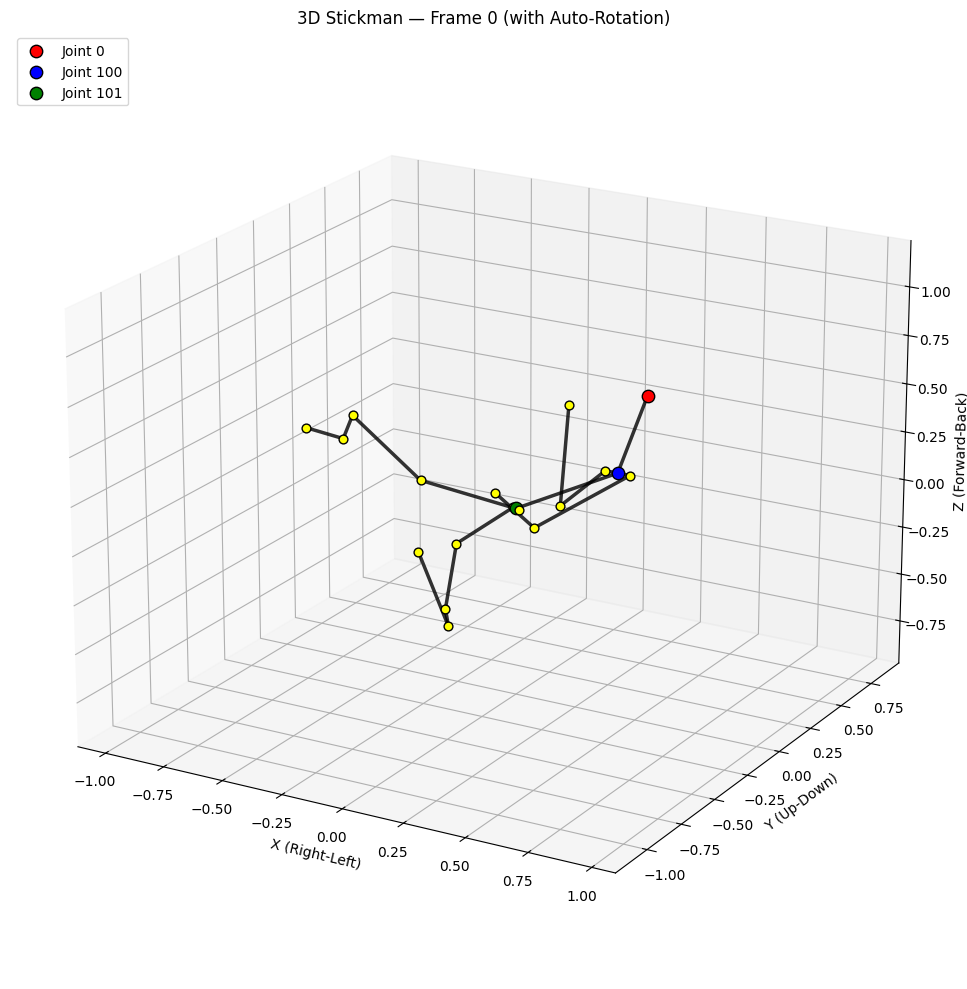

Joint positions (first 5):
  Joint 0: [0.13515925 0.75318773 0.31242139]
  Joint 11: [ 8.56528559e-02  5.18574005e-01 -6.78657553e-18]
  Joint 12: [ 1.90998083e-01  5.18574005e-01 -1.05785291e-17]
  Joint 13: [ 0.09470293  0.16056862 -0.03159341]
  Joint 14: [ 0.00191467  0.13012118 -0.15707867]


In [25]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# ---------------------------------------------------------------------
# Load raw data
# ---------------------------------------------------------------------
def load_and_reduce(path):
    df = pd.read_csv(path)

    useful_ids = [
        0, 11,12, 13,14, 15,16,
        23,24, 25,26, 27,28,
        29,30, 31,32
    ]

    cols = ["timestamp"]
    for jid in useful_ids:
        cols += [f"joint_{jid}_x", f"joint_{jid}_y", f"joint_{jid}_z"]

    df = df[cols]

    # Fix missing values safely
    df = df.ffill().bfill()

    # Convert joint columns to float only
    joint_cols = [c for c in df.columns if c != "timestamp"]
    df[joint_cols] = df[joint_cols].astype(float)

    return df, useful_ids


# ---------------------------------------------------------------------
# Smoothing (safe)
# ---------------------------------------------------------------------
def smooth_data(df):
    coords = df.iloc[:,1:].values

    window = 11
    if window >= len(df):
        window = len(df) - 1 if len(df) % 2 == 0 else len(df)
    if window < 5:
        window = 5
    if window % 2 == 0:
        window += 1

    smoothed = savgol_filter(coords, window_length=window, polyorder=3, axis=0)
    df.iloc[:,1:] = smoothed
    return df

# ---------------------------------------------------------------------
# 1) RESEARCH DATA (NO CENTERING)
# ---------------------------------------------------------------------
def preprocess_for_research(path_in, path_out):
    df, _ = load_and_reduce(path_in)
    df = smooth_data(df)
    df.to_csv(path_out, index=False)
    print("Saved research-quality dataset:", path_out)

# ---------------------------------------------------------------------
# 2) ANIMATION / ANGLE DATA (WITH HIP CENTERING)
# ---------------------------------------------------------------------
def preprocess_for_animation(path_in, path_out):
    df, useful_ids = load_and_reduce(path_in)
    df = smooth_data(df)

    hip_left  = df[["joint_23_x", "joint_23_y", "joint_23_z"]].values
    hip_right = df[["joint_24_x", "joint_24_y", "joint_24_z"]].values
    hip_center = (hip_left + hip_right) / 2

    for jid in useful_ids:
        df[[f"joint_{jid}_x", f"joint_{jid}_y", f"joint_{jid}_z"]] -= hip_center

    df.to_csv(path_out, index=False)
    print("Saved animation-friendly dataset:", path_out)

# ---------------------------------------------------------------------
# Run both versions
# ---------------------------------------------------------------------
preprocess_for_research("data/raw_joints.csv", "data/preprocessed_research.csv")
preprocess_for_animation("data/raw_joints.csv", "data/preprocessed_animation.csv")


Loaded 25410 frames
Columns: ['timestamp', 'joint_0_x', 'joint_0_y', 'joint_0_z', 'joint_11_x', 'joint_11_y', 'joint_11_z', 'joint_12_x', 'joint_12_y', 'joint_12_z', 'joint_13_x', 'joint_13_y', 'joint_13_z', 'joint_14_x', 'joint_14_y', 'joint_14_z', 'joint_15_x', 'joint_15_y', 'joint_15_z', 'joint_16_x']

=== First few rows of data ===
                    timestamp  joint_0_x  joint_0_y  joint_0_z  joint_11_x  \
0  2025-11-28T10:59:56.288425   0.505176  -0.864975   2.771609    0.304300   
1  2025-11-28T10:59:56.372411   0.485870  -0.809904   2.725541    0.243443   
2  2025-11-28T10:59:56.449426   0.474729  -0.779917   2.713036    0.204221   

   joint_11_y  joint_11_z  joint_12_x  joint_12_y  joint_12_z  ...  \
0   -0.642087    2.516519    0.221489   -0.691239    2.559228  ...   
1   -0.631592    2.542144    0.239212   -0.632188    2.528826  ...   
2   -0.625837    2.556866    0.250305   -0.592844    2.500694  ...   

   joint_29_z  joint_30_x  joint_30_y  joint_30_z  joint_31_x  joint

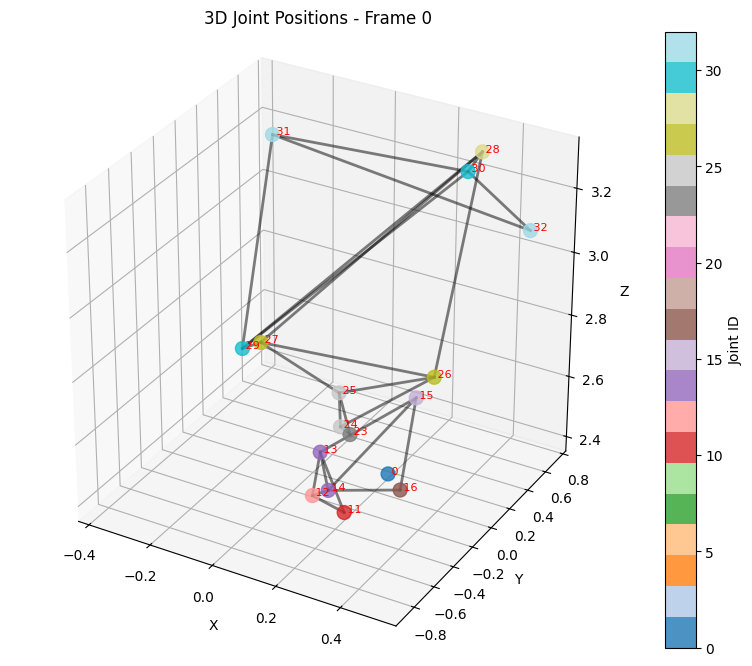

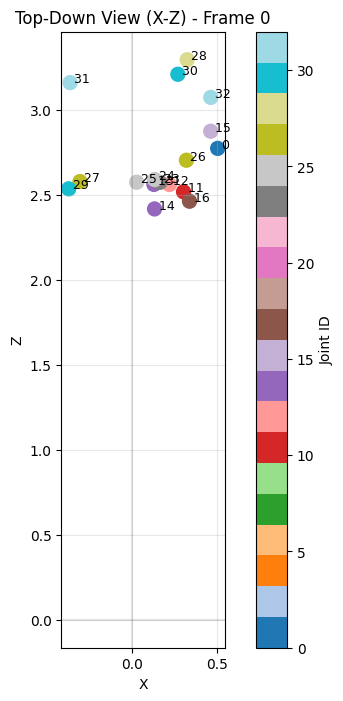

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ========= LOAD DATA ==========
df = pd.read_csv("data/preprocessed_research.csv")
print(f"Loaded {len(df)} frames")
print("Columns:", df.columns.tolist()[:20])  # Show first 20 columns

# ========= SIMPLE PLOT ==========
def plot_simple_stickman(df, frame_idx=0):
    """
    Plot stickman from exact XYZ coordinates in the CSV
    No rotation, no processing - just plot what's there
    """
    
    # Get all joint positions for this frame
    frame_data = df.iloc[frame_idx]
    
    # Extract all joints that exist in the data
    joints = {}
    for col in df.columns:
        if col.startswith("joint_"):
            # Parse: joint_11_x, joint_11_y, joint_11_z
            parts = col.split("_")
            if len(parts) >= 3:
                try:
                    joint_id = int(parts[1])  # e.g., 11 from "joint_11_x"
                    axis = parts[2]  # e.g., "x"
                    
                    if joint_id not in joints:
                        joints[joint_id] = {'x': 0, 'y': 0, 'z': 0}
                    
                    joints[joint_id][axis] = frame_data[col]
                except:
                    continue
    
    print(f"\nFound {len(joints)} joints in frame {frame_idx}")
    
    # Convert to simple lists for plotting
    x_vals = []
    y_vals = []
    z_vals = []
    joint_ids = []
    
    for jid, coords in sorted(joints.items()):
        x_vals.append(coords['x'])
        y_vals.append(coords['y'])
        z_vals.append(coords['z'])
        joint_ids.append(jid)
        print(f"Joint {jid}: ({coords['x']:.3f}, {coords['y']:.3f}, {coords['z']:.3f})")
    
    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot joints as points
    scatter = ax.scatter(x_vals, y_vals, z_vals, 
                         c=joint_ids, cmap='tab20', s=100, alpha=0.8)
    
    # Add labels for joints
    for i, jid in enumerate(joint_ids):
        ax.text(x_vals[i], y_vals[i], z_vals[i], 
                f' {jid}', fontsize=8, color='red')
    
    # Basic skeleton connections (adjust based on your joint IDs)
    # Common connections: connect shoulder to elbow to wrist, hip to knee to ankle
    connections = []
    
    # Try to connect joints that might form limbs
    for jid in joint_ids:
        # Try common limb connections (adjust numbers based on your data)
        if jid + 1 in joint_ids:  # Connect consecutive joints
            connections.append((jid, jid + 1))
        if jid + 2 in joint_ids:  # Skip one joint
            connections.append((jid, jid + 2))
    
    # Draw connections
    for (jid1, jid2) in connections:
        idx1 = joint_ids.index(jid1) if jid1 in joint_ids else None
        idx2 = joint_ids.index(jid2) if jid2 in joint_ids else None
        
        if idx1 is not None and idx2 is not None:
            ax.plot([x_vals[idx1], x_vals[idx2]],
                    [y_vals[idx1], y_vals[idx2]],
                    [z_vals[idx1], z_vals[idx2]], 
                    'k-', alpha=0.5, linewidth=2)
    
    # Labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Joint Positions - Frame {frame_idx}')
    
    # Colorbar to show joint IDs
    plt.colorbar(scatter, ax=ax, label='Joint ID')
    
    # Equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.show()

# ========= PLOT MULTIPLE VIEWS ==========
def plot_top_down(df, frame_idx=0):
    """Simple 2D top-down view (X-Z plane)"""
    frame_data = df.iloc[frame_idx]
    
    joints = {}
    for col in df.columns:
        if col.startswith("joint_"):
            parts = col.split("_")
            if len(parts) >= 3:
                try:
                    joint_id = int(parts[1])
                    axis = parts[2]
                    
                    if joint_id not in joints:
                        joints[joint_id] = {'x': 0, 'z': 0}
                    
                    if axis == 'x':
                        joints[joint_id]['x'] = frame_data[col]
                    elif axis == 'z':
                        joints[joint_id]['z'] = frame_data[col]
                except:
                    continue
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x_vals = []
    z_vals = []
    joint_ids = []
    
    for jid, coords in sorted(joints.items()):
        x_vals.append(coords['x'])
        z_vals.append(coords['z'])
        joint_ids.append(jid)
    
    # Plot
    scatter = ax.scatter(x_vals, z_vals, c=joint_ids, cmap='tab20', s=100)
    
    # Labels
    for i, jid in enumerate(joint_ids):
        ax.text(x_vals[i], z_vals[i], f' {jid}', fontsize=9)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title(f'Top-Down View (X-Z) - Frame {frame_idx}')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.1)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.1)
    ax.set_aspect('equal')
    
    plt.colorbar(scatter, ax=ax, label='Joint ID')
    plt.show()

# ========= EXECUTE ==========
# First, see what joints we have
print("\n=== First few rows of data ===")
print(df.head(3))

# Plot 3D view
plot_simple_stickman(df, 0)

# Plot 2D top-down view
plot_top_down(df, 0)

# Optional: If you want to see more frames
# for i in range(min(3, len(df))):
#     plot_simple_stickman(df, i)